In [1]:
import Pkg
Pkg.activate("/home/matteo/Projects/PhyloBM")

  Activating project at `~/Projects/PhyloBM`


In [2]:
using Revise

In [3]:
using PyPlot, FileIO, PottsEvolver, FastaIO, BioSeqInt, TreeCorr, TreeTools, StatsBase, LinearAlgebra, MultivariateStats, Flux, Distributions, Statistics, Random

/home/matteo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
using SequenceLogos: logo_from_matrix, plot_sequence_logo_aa

In [5]:
import PyPlot.subplots
subplots(x,y,d) = subplots(x,y, figsize=(y*d, x*d))

subplots (generic function with 2 methods)

In [6]:
function pairwise_dist(seqs::Matrix, n_samples)
    
    sample_idx = randperm(size(seqs,2))[1:n_samples]
    dist_pairwise = zeros(Int, n_samples*(n_samples-1)÷2)
    cnt =1
    for i in 1:n_samples
        for j in 1:i-1
            dist_pairwise[cnt] = sum(seqs[:,sample_idx[i]] .!= seqs[:,sample_idx[j]])
            cnt += 1
        end
    end

    return dist_pairwise
end

pairwise_dist (generic function with 1 method)

In [7]:
function compute_corr_matrix(z)
    q = max(20, maximum(z))
    L, M = size(z)

    fi = zeros(q, L)
    for m in 1:M
        for i in 1:L
            fi[z[i,m], i] += 1.0
        end
    end
    fi ./= M
    fi = reshape(fi, q*L, 1)

    fij = zeros(q, L, q, L)
    for m in 1:M
        for i in 1:L
            for j in 1:L
                fij[z[i,m], i, z[j,m], j] += 1.0
            end
        end
    end
    fij ./= M
    fij = reshape(fij, q*L, q*L)

    return fij .- fi*fi'
end

compute_corr_matrix (generic function with 1 method)

# Potts model

In [8]:
file_params_no_reweight = "/home/matteo/Projects/PhyloBM/DBD/notebooks/params_no_reweight.dat"
lines = readlines(file_params_no_reweight)
L = parse(Int, split(lines[end])[2]) + 1
q = length(aa_alphabet.char_to_index)
J_no_reweight = zeros(q, q, L, L)
h_no_reweight = zeros(q, L)
for line in lines
    fields =split(line)
    if (length(fields) == 6) && (fields[1] == "J")
        _, i, j, ai, aj, val = fields
        J_no_reweight[aa_alphabet.char_to_index[ai[1]],  aa_alphabet.char_to_index[aj[1]], parse(Int, i)+1, parse(Int, j)+1] = parse(Float64, val)
        J_no_reweight[aa_alphabet.char_to_index[aj[1]], aa_alphabet.char_to_index[ai[1]], parse(Int, j)+1,  parse(Int, i)+1] = parse(Float64, val)
    elseif (length(fields) == 4) && (fields[1] == "h")
        _, i, ai, val = fields
        h_no_reweight[aa_alphabet.char_to_index[ai[1]], parse(Int, i)+1] = parse(Float64, val)
    else
        print(line * ": Unrecognized format for parameter.")
        break
    end
end

In [9]:
potts_no_reweight = PottsGraph(J_no_reweight, h_no_reweight, 1.0, aa_alphabet)
potts_no_reweight

PottsGraph{Float64}: dimensions (L=76, q=21) -- β=1.0 -- Alphabet{Char,Int64}: ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [10]:
file_params_reweight = "/home/matteo/Projects/PhyloBM/DBD/notebooks/params_reweight.dat"
lines = readlines(file_params_reweight)
L = parse(Int, split(lines[end])[2]) + 1
q = length(aa_alphabet.char_to_index)
J_reweight = zeros(q, q, L, L)
h_reweight = zeros(q, L)
for line in lines
    fields =split(line)
    if (length(fields) == 6) && (fields[1] == "J")
        _, i, j, ai, aj, val = fields
        J_reweight[aa_alphabet.char_to_index[ai[1]],  aa_alphabet.char_to_index[aj[1]], parse(Int, i)+1, parse(Int, j)+1] = parse(Float64, val)
        J_reweight[aa_alphabet.char_to_index[aj[1]], aa_alphabet.char_to_index[ai[1]], parse(Int, j)+1,  parse(Int, i)+1] = parse(Float64, val)
    elseif (length(fields) == 4) && (fields[1] == "h")
        _, i, ai, val = fields
        h_reweight[aa_alphabet.char_to_index[ai[1]], parse(Int, i)+1] = parse(Float64, val)
    else
        print(line * ": Unrecognized format for parameter.")
        break
    end
end

In [11]:
potts_reweight = PottsGraph(J_reweight, h_reweight, 1.0, aa_alphabet)
potts_reweight

PottsGraph{Float64}: dimensions (L=76, q=21) -- β=1.0 -- Alphabet{Char,Int64}: ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# MSA

In [12]:
fasta_dbd = "/home/matteo/Data/DBD/DBD_alignment.uniref90.cov80_clean.a2m";

In [13]:
wt_int = [2,10,18,2,6,3,15,1,16,6,20,7,20,6,18,10,16,2,4,6,2,9,1,5,5,9,15,16,8,14,6,16,18,4,20,17,2,13,1,
17,12,4,2,9,8,3,9,7,15,15,9,16,2,14,1,2,15,10,14,9,2,5,4,18,6,11,11,9,4,6,18,15,9,3,15,12]
wt_int = map(x -> x == q ? 1 : x+1, wt_int)
wt_seq = map(x-> aa_alphabet.index_to_char[x], wt_int)|> String

@assert length(wt_seq) == L

Logo natural sequences

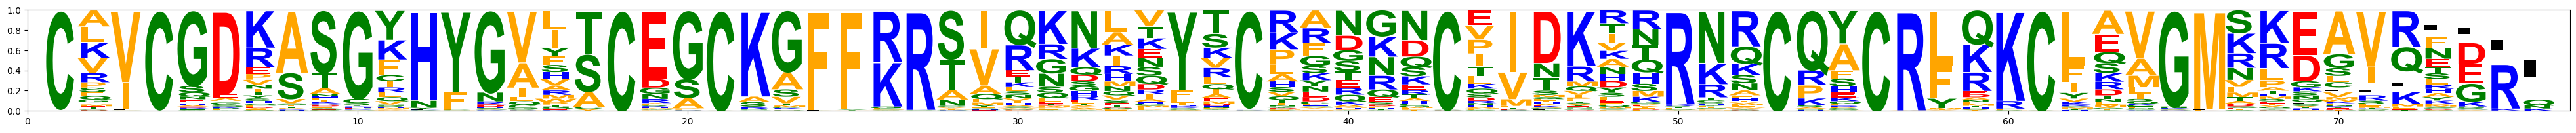

In [14]:
figure(figsize=(50,2))
logo_from_matrix(compute_frequencies(fasta_dbd, q=q, L=L, char_to_int=aa_alphabet.char_to_index),
    String(map(x->aa_alphabet.index_to_char[x], collect(1:q)))) |> plot_sequence_logo_aa
gcf()

Wild type logo

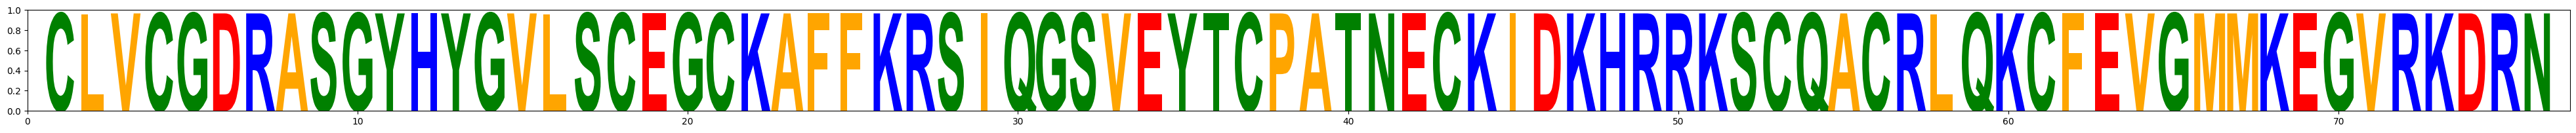

In [15]:
figure(figsize=(50,2))
logo_from_matrix(compute_frequencies([wt_seq], q=q, L=L, char_to_int=aa_alphabet.char_to_index),
    String(map(x->aa_alphabet.index_to_char[x], collect(1:q)))) |> plot_sequence_logo_aa
gcf()

In [16]:
msa_fasta = readfasta(fasta_dbd)
msa_z = zeros(Int, L, length(msa_fasta))
for (id, entry) in pairs(msa_fasta)
    seq = collect(entry[2])
    for (i, aa) in pairs(seq)
        msa_z[i, id] = aa_alphabet.char_to_index[aa]
    end
end
msa_z
        

76×24944 Matrix{Int64}:
  3   3   3   3   3   3   3   3   3  …   3   1   3   3   3   3   3   3   3
 19  19   5   5   5  16   2   2  19     10   1  11   2   2  14  16  11  11
  7   7   9   9   9  19  19  19  19     19   1  19  19  19  19  19  19  19
  3   3   3   3   3   3   3   3   3      3   1   3   3   3   3   3   3   3
  7   7   5   5   5   7   7   7   5      7   1   7   7   7   7   7   7   7
 17  17  17  17  17   4   4   4   4  …   4   1   4   4   4   4   4   4   4
  5   5  18  18  18   7  21  14  14     10   1  19  13  13  10  10  10  16
 17  17   2   2   2  13  14  17  16     17   1   2   2   2  19   2   2   2
 17  17  16  16  16   2   2  18   7     17  17  17   2   2  17  17  11  17
 16  16  17  17  17  10  10   7  17      7   7   7   3   3   7   7   7   7
  ⋮                   ⋮              ⋱   ⋮                   ⋮          
 14  14  16  16  16  14  14  19  14     16  16  10  10  10  11  16  10  14
 10  10   5   5   5  10   4  21   7      4   5   5   5   5   5   4   5   5
  8

In [17]:
msa_energies_no_reweight = map(x->energy(x, potts_no_reweight), eachcol(msa_z))
wt_energy_no_reweight = energy(wt_int, potts_no_reweight)

73.65591634735964

In [18]:
msa_energies_reweight = map(x->energy(x, potts_reweight), eachcol(msa_z))
wt_energy_reweight = energy(wt_int, potts_reweight)

95.21512772124598

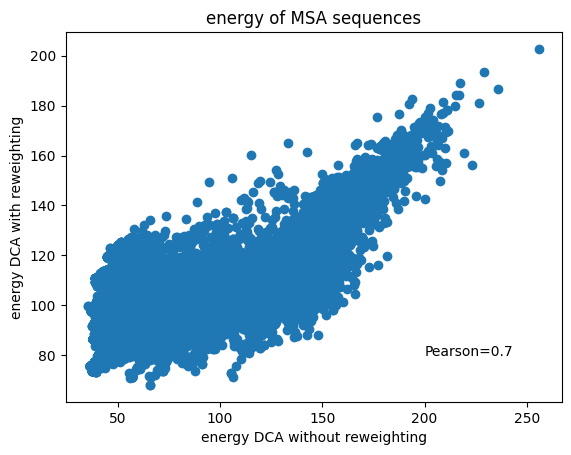

In [19]:
figure()
scatter(msa_energies_no_reweight, msa_energies_reweight)
xlabel("energy DCA without reweighting")
ylabel("energy DCA with reweighting")
title("energy of MSA sequences")
p_coeff = cor(msa_energies_no_reweight, msa_energies_reweight)
text(200, 80, "Pearson=" * string(round(p_coeff, digits=2)))
gcf()

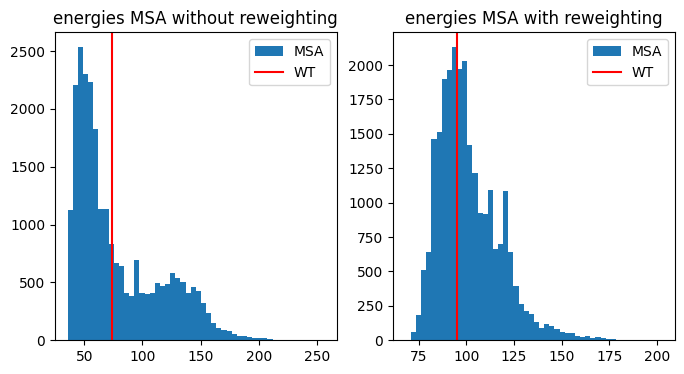

In [20]:
fig, ax = subplots(1, 2,4)

ax[1].hist(msa_energies_no_reweight, bins=50, label="MSA")
ax[1].axvline(wt_energy_no_reweight, color="red", label="WT")
ax[1].set_title("energies MSA without reweighting")
ax[1].legend()

ax[2].hist(msa_energies_reweight, bins=50, label="MSA")
ax[2].axvline(wt_energy_reweight, color="red", label="WT")
ax[2].set_title("energies MSA with reweighting")
ax[2].legend()

gcf()

# MCMC at equilibrium

In [21]:
n_trajectories_eq = 5
n_points_eq = 1000
parameters_eq = SamplingParameters(Teq=L, burnin=0, step_meaning=:proposed)

results_eq_wt_no_reweight = [mcmc_sample(potts_no_reweight, n_points_eq, parameters_eq, init=wt_int) for i in 1:n_trajectories_eq]
results_eq_random_no_reweight = [mcmc_sample(potts_no_reweight, n_points_eq, parameters_eq, init=:random_aa) for i in 1:n_trajectories_eq]

results_eq_wt_reweight = [mcmc_sample(potts_reweight, n_points_eq, parameters_eq, init=wt_int) for i in 1:n_trajectories_eq]
results_eq_random_reweight = [mcmc_sample(potts_reweight, n_points_eq, parameters_eq, init=:random_aa) for i in 1:n_trajectories_eq]

5-element Vector{@NamedTuple{sequences::Alignment{Char, Int64}, tvals::Vector{Int64}, info::Vector{Any}, params::Dict{Any, Any}}}:
 (sequences = Alignment of M=1000 sequences of length L=76, tvals = [0, 76, 152, 228, 304, 380, 456, 532, 608, 684  …  75240, 75316, 75392, 75468, 75544, 75620, 75696, 75772, 75848, 75924], info = [(proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0)  …  (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performe

In [22]:
energies_eq_wt_no_reweight = [map(x -> energy(x, potts_no_reweight), res.sequences) for res in results_eq_wt_no_reweight]
energies_eq_random_no_reweight = [map(x -> energy(x, potts_no_reweight), res.sequences) for res in results_eq_random_no_reweight]

energies_eq_wt_reweight = [map(x -> energy(x, potts_reweight), res.sequences) for res in results_eq_wt_reweight]
energies_eq_random_reweight = [map(x -> energy(x, potts_reweight), res.sequences) for res in results_eq_random_reweight];

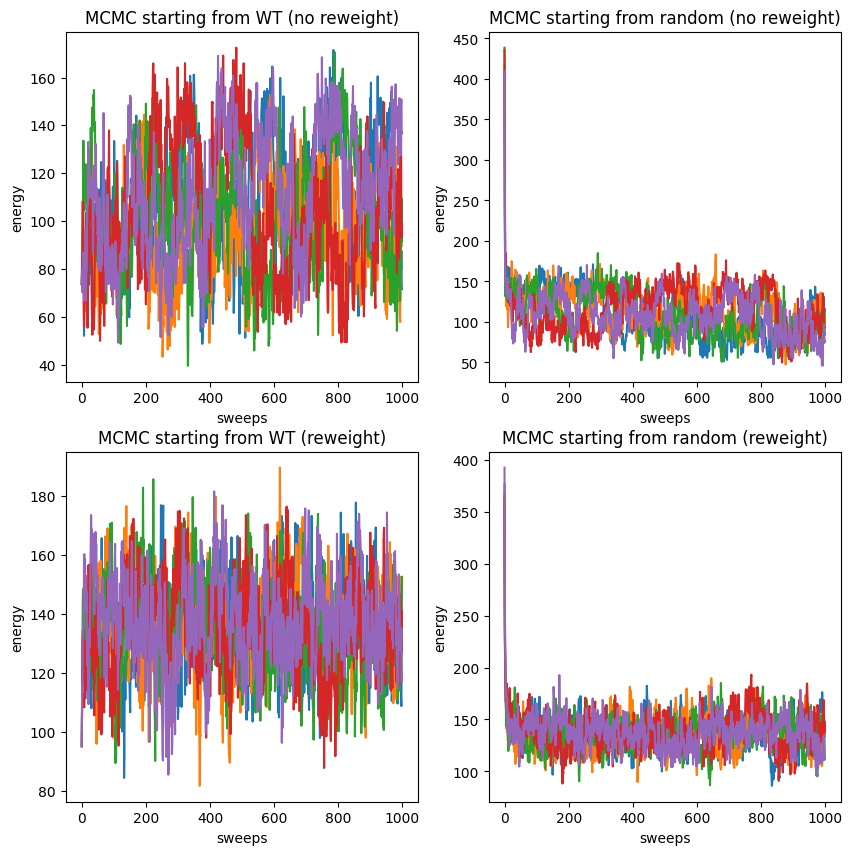

In [23]:
fig, ax = subplots(2, 2, 5)

ax[1,1].plot.(energies_eq_wt_no_reweight)
ax[1,1].set_xlabel("sweeps")
ax[1,1].set_ylabel("energy")
ax[1,1].set_title("MCMC starting from WT (no reweight)")

ax[1,2].plot.(energies_eq_random_no_reweight)
ax[1,2].set_xlabel("sweeps")
ax[1,2].set_ylabel("energy")
ax[1,2].set_title("MCMC starting from random (no reweight)")

ax[2,1].plot.(energies_eq_wt_reweight)
ax[2,1].set_xlabel("sweeps")
ax[2,1].set_ylabel("energy")
ax[2,1].set_title("MCMC starting from WT (reweight)")

ax[2,2].plot.(energies_eq_random_reweight)
ax[2,2].set_xlabel("sweeps")
ax[2,2].set_ylabel("energy")
ax[2,2].set_title("MCMC starting from random (reweight)")

gcf()

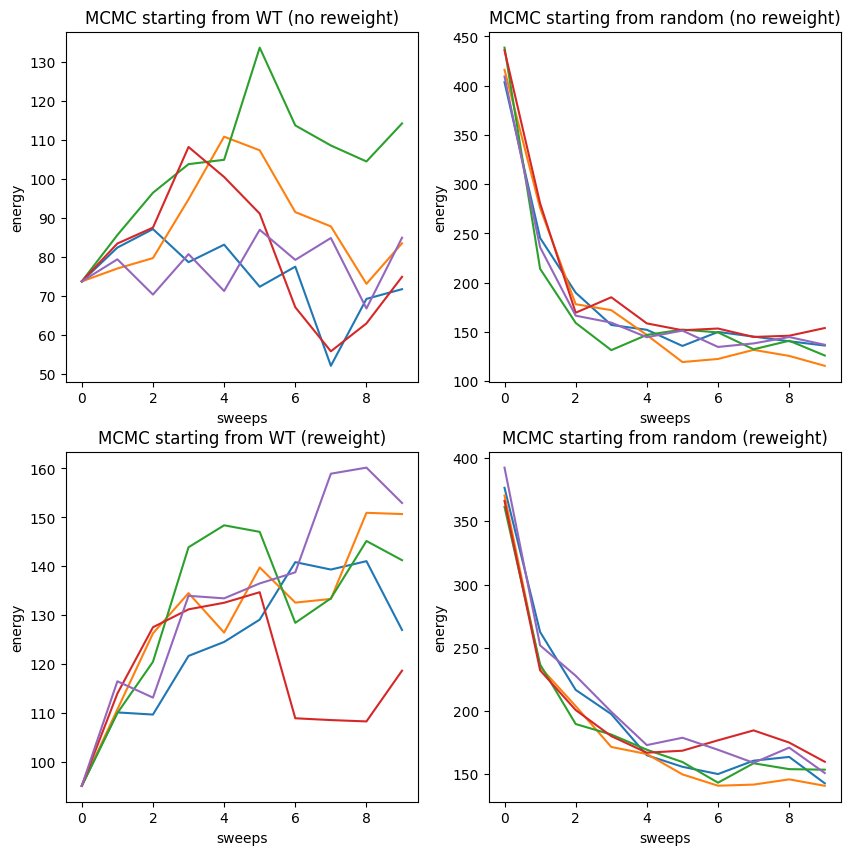

In [24]:
fig, ax = subplots(2, 2, 5)

tfin = 10

ax[1,1].plot.(map(x->x[1:tfin], energies_eq_wt_no_reweight))
ax[1,1].set_xlabel("sweeps")
ax[1,1].set_ylabel("energy")
ax[1,1].set_title("MCMC starting from WT (no reweight)")

ax[1,2].plot.(map(x->x[1:tfin], energies_eq_random_no_reweight))
ax[1,2].set_xlabel("sweeps")
ax[1,2].set_ylabel("energy")
ax[1,2].set_title("MCMC starting from random (no reweight)")

ax[2,1].plot.(map(x->x[1:tfin], energies_eq_wt_reweight))
ax[2,1].set_xlabel("sweeps")
ax[2,1].set_ylabel("energy")
ax[2,1].set_title("MCMC starting from WT (reweight)")

ax[2,2].plot.(map(x->x[1:tfin], energies_eq_random_reweight))
ax[2,2].set_xlabel("sweeps")
ax[2,2].set_ylabel("energy")
ax[2,2].set_title("MCMC starting from random (reweight)")

gcf()

Equilibrium samples logo

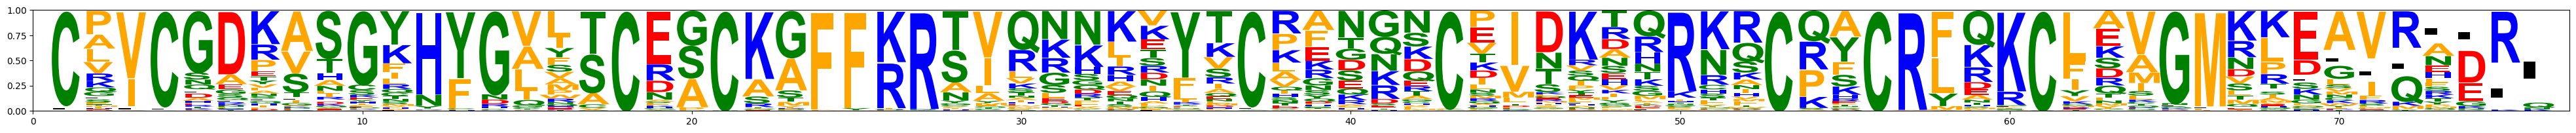

In [25]:
figure(figsize=(50,2))
logo_from_matrix(TreeCorr.compute_frequencies_from(results_eq_random_no_reweight[1].sequences.data, q=q),
    String(map(x->aa_alphabet.index_to_char[x], collect(1:q)))) |> plot_sequence_logo_aa
gcf()

# MCMC transient

In [26]:
n_samples_mcmc = 2^12

4096

Check divergence

In [27]:
sweeps_step = L÷2
sweeps_samples = 20
parameters_mcmc_sweeps = SamplingParameters(Teq=sweeps_step, burnin=0, step_meaning=:proposed)
results_mcmc_sweeps_no_reweight = [mcmc_sample(potts_no_reweight, sweeps_samples, parameters_mcmc_sweeps, init=wt_int) for _ in 1:n_samples_mcmc]
results_mcmc_sweeps_reweight = [mcmc_sample(potts_reweight, sweeps_samples, parameters_mcmc_sweeps, init=wt_int) for _ in 1:n_samples_mcmc];

In [28]:
dist_wt_natural = [sum(msa_z[:,i] .== wt_int) for i in axes(msa_z, 2)]
dist_wt_sweeps_no_reweight = [map(x->sum(x.sequences.data[:,i] .!= wt_int), results_mcmc_sweeps_no_reweight) for i in 1:sweeps_samples]
dist_wt_sweeps_reweight = [map(x->sum(x.sequences.data[:,i] .!= wt_int), results_mcmc_sweeps_reweight) for i in 1:sweeps_samples];

In [29]:
pairwise_dist_natural = pairwise_dist(msa_z, 2000)
pairwise_dist_sweeps_no_reweight = [pairwise_dist(hcat(map(x->x.sequences.data[:,i], results_mcmc_sweeps_no_reweight)...), 2000) for i in 1:sweeps_samples]
pairwise_dist_sweeps_reweight = [pairwise_dist(hcat(map(x->x.sequences.data[:,i], results_mcmc_sweeps_reweight)...), 2000) for i in 1:sweeps_samples];

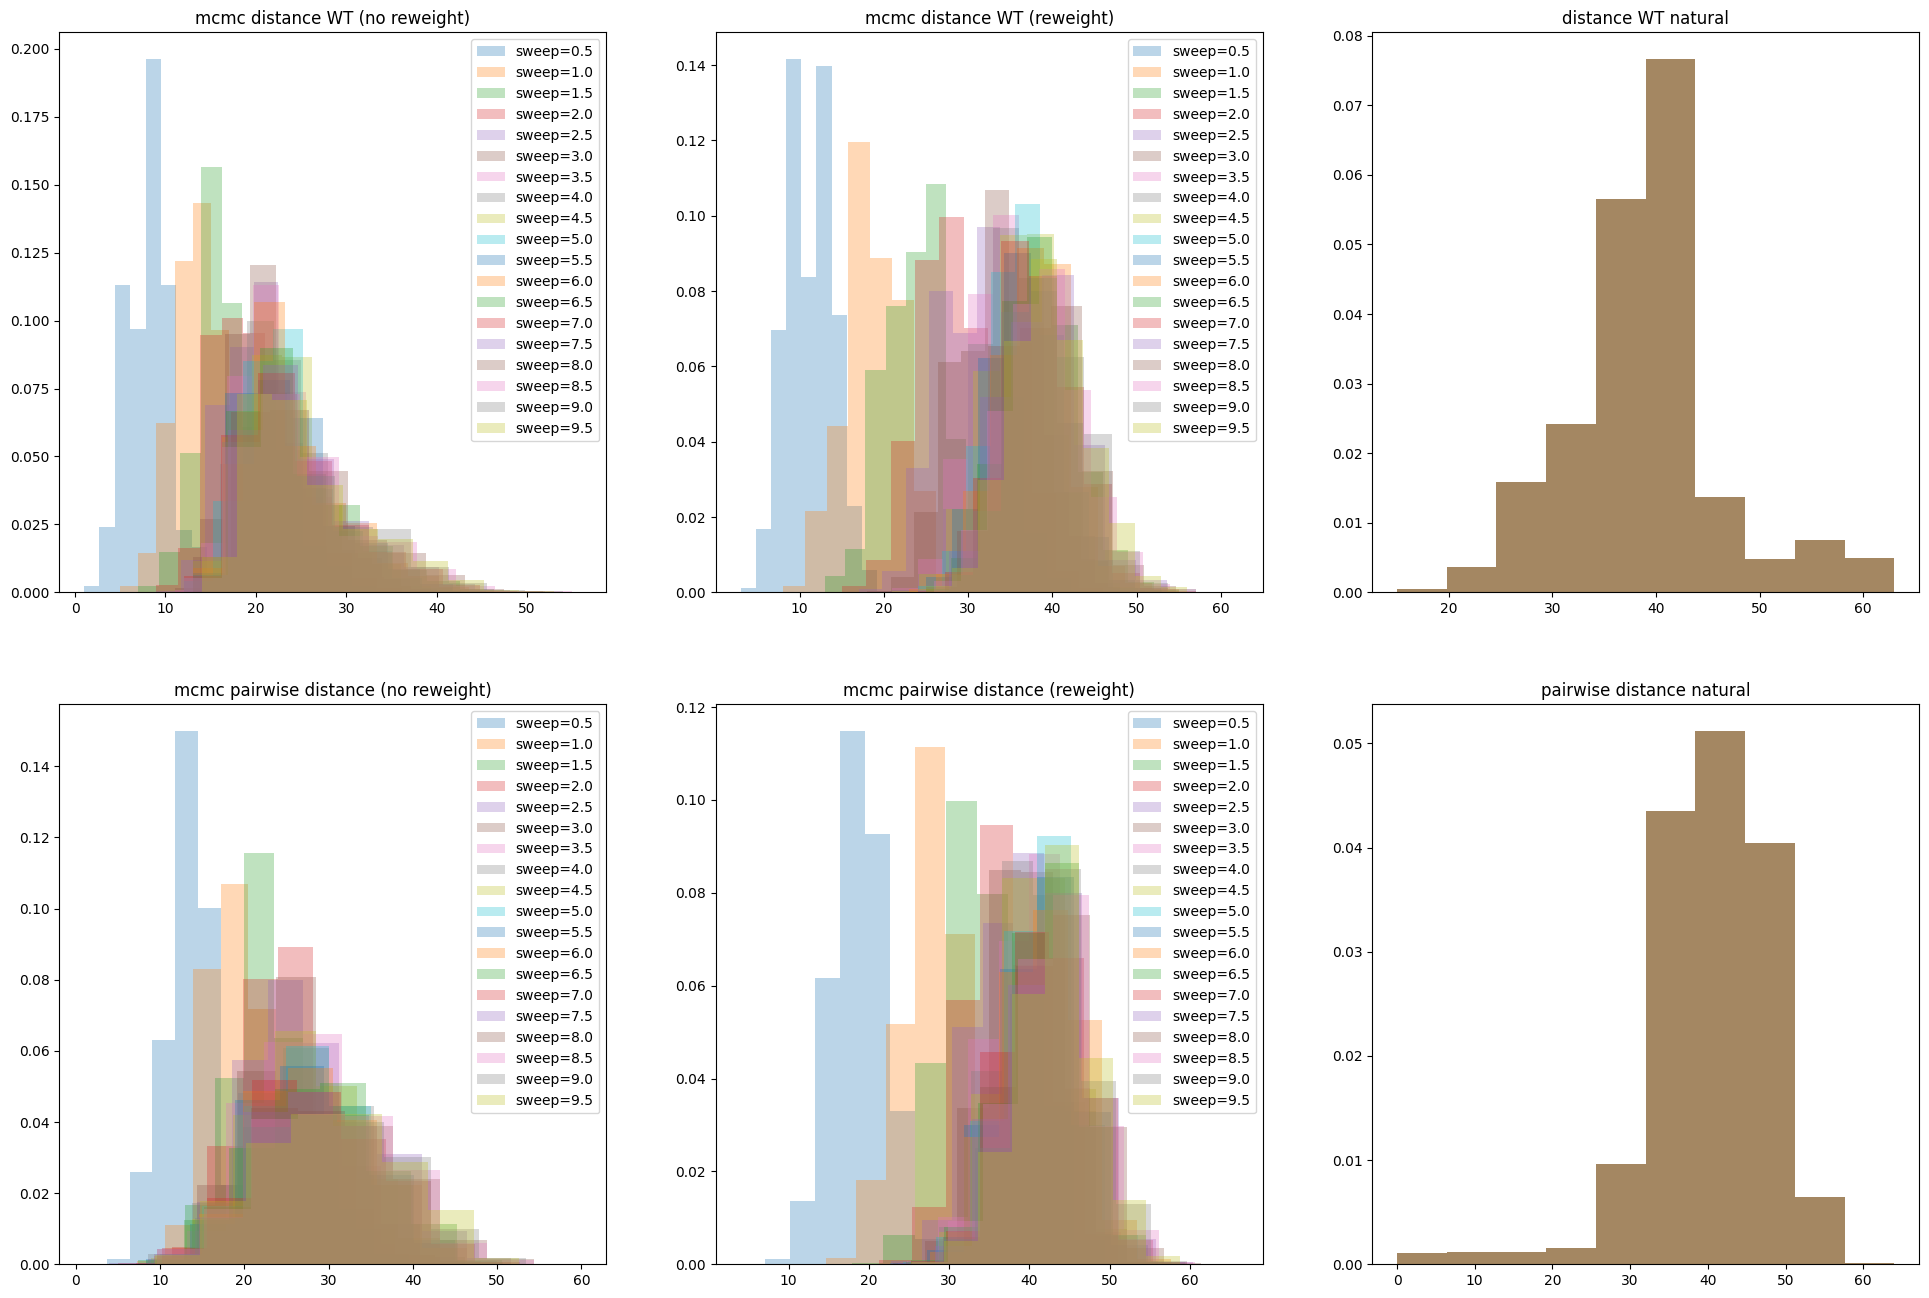

In [30]:
fig, ax = subplots(2,3,8)
for i in 2:sweeps_samples

    ax[1,1].hist(dist_wt_sweeps_no_reweight[i], label="sweep=$((i-1)*sweeps_step/L)", alpha=0.3, density=true)
    ax[1,1].legend()
    ax[1,1].set_title("mcmc distance WT (no reweight)")
    ax[1,2].hist(dist_wt_sweeps_reweight[i], label="sweep=$((i-1)*sweeps_step/L)", alpha=0.3, density=true)
    ax[1,2].set_title("mcmc distance WT (reweight)")
    ax[1,2].legend()
    ax[1,3].hist(dist_wt_natural, label="natural", alpha=0.3, density=true)
    ax[1,3].set_title("distance WT natural")

    ax[2,1].hist(pairwise_dist_sweeps_no_reweight[i], label="sweep=$((i-1)*sweeps_step/L)", alpha=0.3, density=true)
    ax[2,1].legend()
    ax[2,1].set_title("mcmc pairwise distance (no reweight)")
    ax[2,2].hist(pairwise_dist_sweeps_reweight[i], label="sweep=$((i-1)*sweeps_step/L)", alpha=0.3, density=true)
    ax[2,2].set_title("mcmc pairwise distance (reweight)")
    ax[2,2].legend()
    ax[2,3].hist(pairwise_dist_natural, label="natural", alpha=0.3, density=true)
    ax[2,3].set_title("pairwise distance natural")
end
gcf()

Simulation

In [73]:
n_sweep_mcmc = [1, 2, 3, 5, 10, 15]
msa_mcmc_no_reweight = Dict()
msa_mcmc_reweight = Dict()

for n_sweep in n_sweep_mcmc
    parameters_mcmc = SamplingParameters(Teq=1, burnin=n_sweep*L-1, step_meaning=:proposed)

    results_mcmc_no_reweight = [mcmc_sample(potts_no_reweight, 1, parameters_mcmc, init=wt_int) for _ in 1:n_samples_mcmc]
    push!(msa_mcmc_no_reweight, n_sweep=> hcat(map(x->x.sequences.data , results_mcmc_no_reweight)...))

    results_mcmc_reweight = [mcmc_sample(potts_reweight, 1, parameters_mcmc, init=wt_int) for _ in 1:n_samples_mcmc]
    push!(msa_mcmc_reweight, n_sweep=>hcat(map(x->x.sequences.data , results_mcmc_reweight)...))
end

# Simulation on a tree

In [74]:
n_samples_tree = 2^12
bd_tree = Dict()

for n_sweep in n_sweep_mcmc
    b_rate_tree = inv(n_sweep / (log(n_samples_tree-1)+0.577))
    yule = TreeTools.Generate.YuleCoalescent(n=n_samples_tree, b=b_rate_tree)
    push!(bd_tree, n_sweep => TreeTools.Generate.genealogy(yule))

    dist_root = distance(bd_tree[n_sweep].root, first(leaves(bd_tree[n_sweep])))
    println("n_sweep=$n_sweep/ distance root: ", dist_root)
end

n_sweep=1/ distance root: 0.8827888411740539
n_sweep=2/ distance root: 1.542925878936424
n_sweep=3/ distance root: 2.6132628863413503
n_sweep=5/ distance root: 3.886073257116975
n_sweep=10/ distance root: 8.167625943666026
n_sweep=15/ distance root: 12.876668332107446


In [75]:
blm = PottsEvolver.BranchLengthMeaning(:sweep, :round)
parameters_tree = SamplingParameters(Teq=0, burnin=0, step_meaning=:proposed, branchlength_meaning=blm)

msa_tree = Dict()

for n_sweep in n_sweep_mcmc
    results_tree = mcmc_sample(potts_reweight, bd_tree[n_sweep], parameters_tree, init=wt_int)
    push!(msa_tree,  n_sweep=>results_tree.leaf_sequences.data)
end

# Analysis

### Logos

Logo sample MCMC (no reweight)

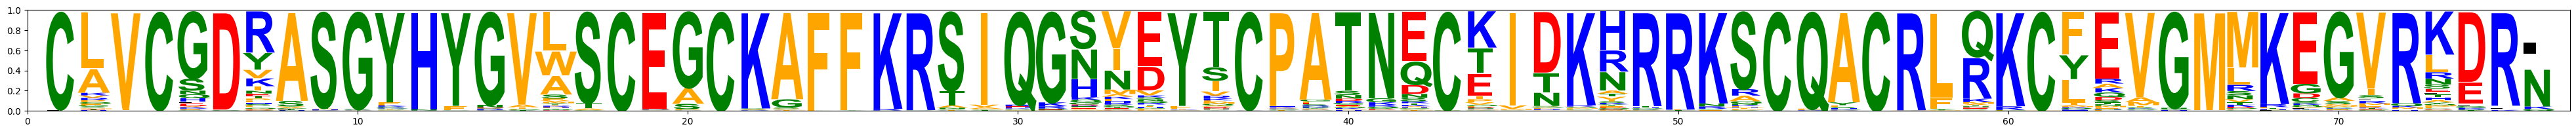

In [34]:
figure(figsize=(50,2))
logo_from_matrix(TreeCorr.compute_frequencies_from(msa_mcmc_no_reweight, q=q),
    String(map(x->aa_alphabet.index_to_char[x], collect(1:q)))) |> plot_sequence_logo_aa
gcf()

Logo sample MCMC (reweighted)

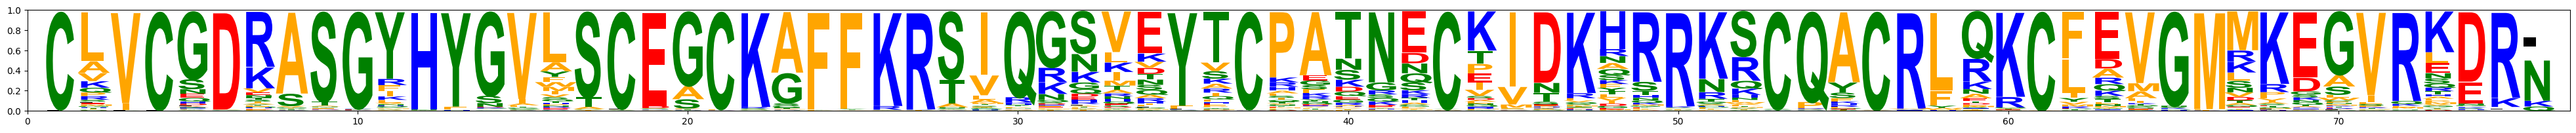

In [35]:
figure(figsize=(50,2))
logo_from_matrix(TreeCorr.compute_frequencies_from(msa_mcmc_reweight, q=q),
    String(map(x->aa_alphabet.index_to_char[x], collect(1:q)))) |> plot_sequence_logo_aa
gcf()

Logo sample Tree

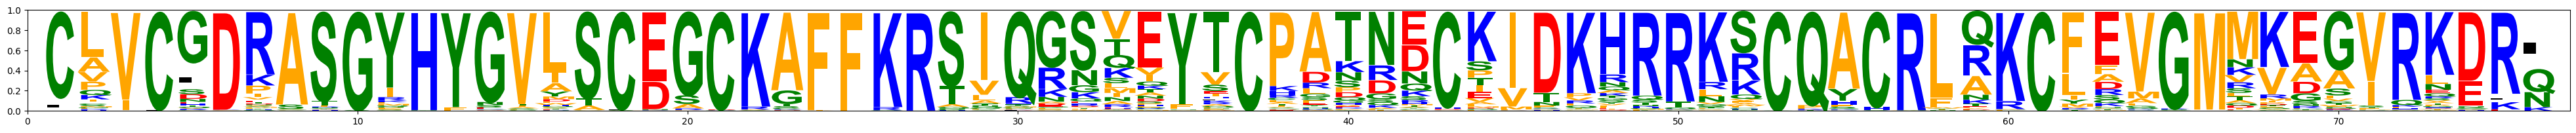

In [36]:
figure(figsize=(50,2))
logo_from_matrix(TreeCorr.compute_frequencies_from(msa_tree, q=q),
    String(map(x->aa_alphabet.index_to_char[x], collect(1:q)))) |> plot_sequence_logo_aa
gcf()

### Pairwise distance

In [76]:
dist_pairwise_mcmc_no_reweight = Dict()
dist_pairwise_mcmc_reweight = Dict()
dist_pairwise_tree = Dict()

for n_sweep in n_sweep_mcmc
    push!(dist_pairwise_mcmc_no_reweight, n_sweep => pairwise_dist(msa_mcmc_no_reweight[n_sweep], 1000)) 
    push!(dist_pairwise_mcmc_reweight, n_sweep => pairwise_dist(msa_mcmc_reweight[n_sweep], 1000))
    push!(dist_pairwise_tree, n_sweep =>  pairwise_dist(msa_tree[n_sweep], 1000))
end

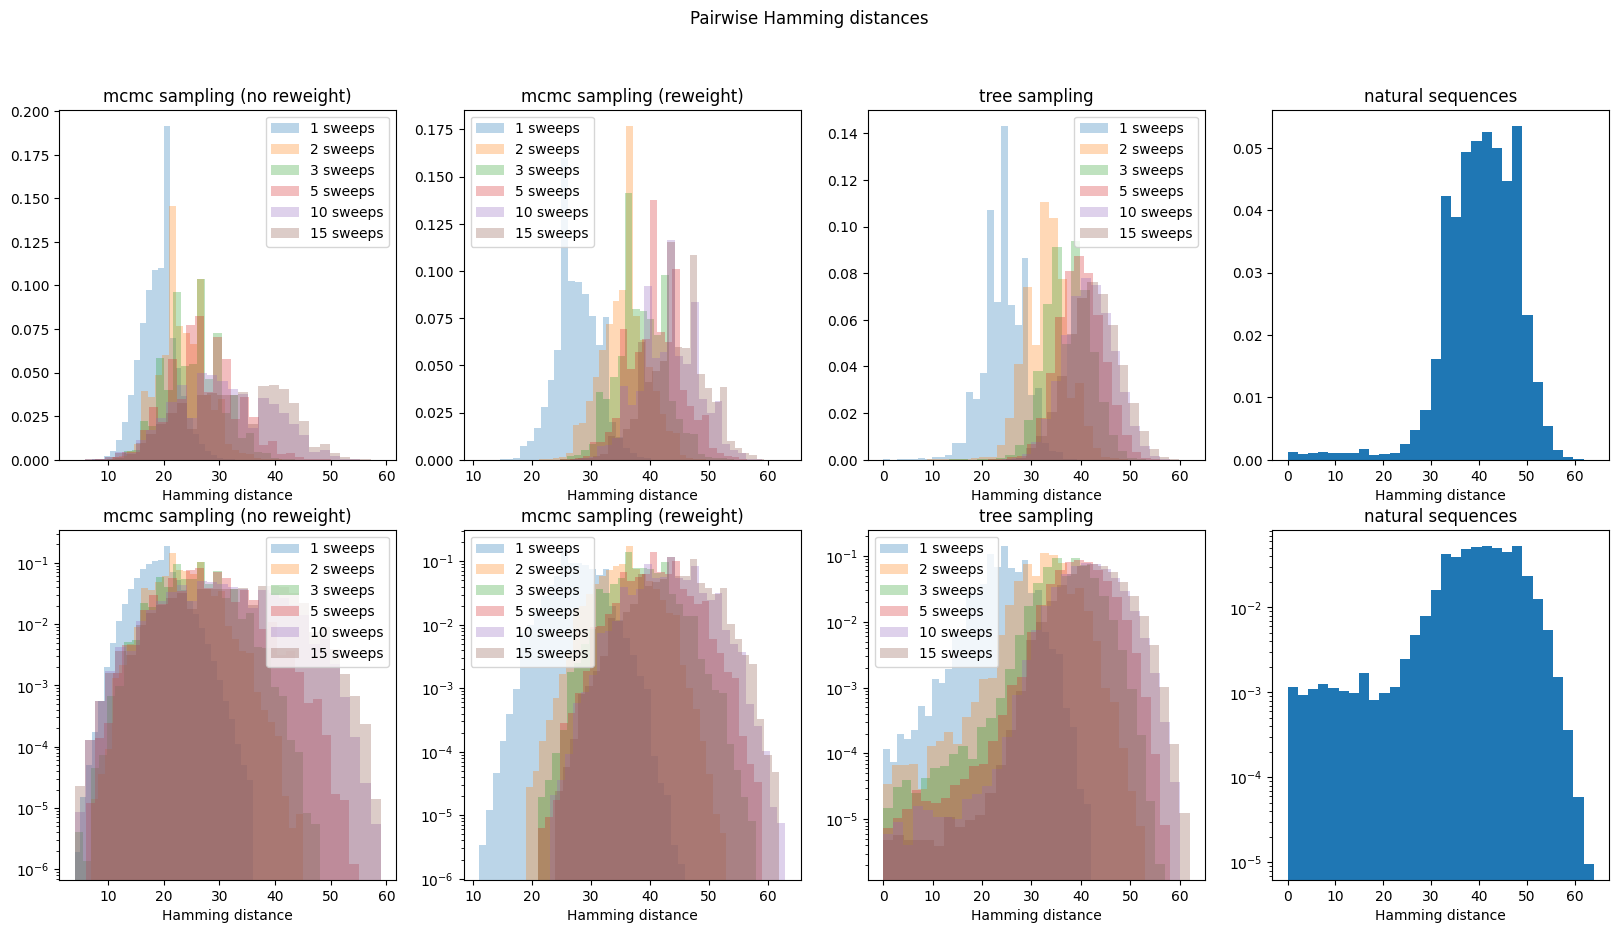

In [77]:
fig, ax = subplots(2,4,5)
fig.suptitle("Pairwise Hamming distances")

for n_sweep in n_sweep_mcmc

    # MCMC no reweight
    ax[1,1].hist(dist_pairwise_mcmc_no_reweight[n_sweep], bins=30, label="$n_sweep sweeps", alpha=0.3, density=true)
    ax[1,1].set_title("mcmc sampling (no reweight)")
    ax[1,1].set_xlabel("Hamming distance")
    ax[1,1].legend()

    ax[2,1].hist(dist_pairwise_mcmc_no_reweight[n_sweep], bins=30, label="$n_sweep sweeps", alpha=0.3, density=true)
    ax[2,1].set_title("mcmc sampling (no reweight)")
    ax[2,1].set_xlabel("Hamming distance")
    ax[2,1].set_yscale(:log)
    ax[2,1].legend()

    # MCMC reweight
    ax[1,2].hist(dist_pairwise_mcmc_reweight[n_sweep], bins=30, label="$n_sweep sweeps", alpha=0.3, density=true)
    ax[1,2].set_title("mcmc sampling (reweight)")
    ax[1,2].set_xlabel("Hamming distance")
    ax[1,2].legend()

    ax[2,2].hist(dist_pairwise_mcmc_reweight[n_sweep], bins=30, label="$n_sweep sweeps", alpha=0.3, density=true)
    ax[2,2].set_title("mcmc sampling (reweight)")
    ax[2,2].set_xlabel("Hamming distance")
    ax[2,2].set_yscale(:log)
    ax[2,2].legend()

    #TREE
    ax[1,3].hist(dist_pairwise_tree[n_sweep], bins=30, label="$n_sweep sweeps", alpha=0.3, density=true)
    ax[1,3].set_xlabel("Hamming distance")
    ax[1,3].set_title("tree sampling")
    ax[1,3].legend()

    ax[2,3].hist(dist_pairwise_tree[n_sweep], bins=30, label="$n_sweep sweeps", alpha=0.3, density=true)
    ax[2,3].set_xlabel("Hamming distance")
    ax[2,3].set_title("tree sampling")
    ax[2,3].set_yscale(:log)
    ax[2,3].legend()
end

ax[1,4].hist(pairwise_dist_natural, bins=30, density=true)
ax[1,4].set_xlabel("Hamming distance")
ax[1,4].set_title("natural sequences")

ax[2,4].hist(pairwise_dist_natural, bins=30, density=true)
ax[2,4].set_xlabel("Hamming distance")
ax[2,4].set_title("natural sequences")
ax[2,4].set_yscale(:log)


gcf()

### Correlation matrix

In [78]:
cor_natural = compute_corr_matrix(msa_z)
cor_mcmc_no_reweight = Dict()
cor_mcmc_reweight = Dict()
cor_tree = Dict()

for n_sweep in n_sweep_mcmc
    push!(cor_mcmc_no_reweight, n_sweep => compute_corr_matrix(msa_mcmc_no_reweight[n_sweep]))
    push!(cor_mcmc_reweight, n_sweep => compute_corr_matrix(msa_mcmc_reweight[n_sweep]))
    push!(cor_tree, n_sweep => compute_corr_matrix(msa_tree[n_sweep]))
end

In [79]:
spectrum_natural = eigen(cor_natural).values;
spectrum_mcmc_no_reweight = Dict()
spectrum_mcmc_reweight = Dict()
spectrum_tree = Dict()

for n_sweep in n_sweep_mcmc
    push!(spectrum_mcmc_no_reweight, n_sweep => eigen(cor_mcmc_no_reweight[n_sweep]).values)
    push!(spectrum_mcmc_reweight, n_sweep => eigen(cor_mcmc_reweight[n_sweep]).values)
    push!(spectrum_tree, n_sweep => eigen(cor_tree[n_sweep]).values)
end

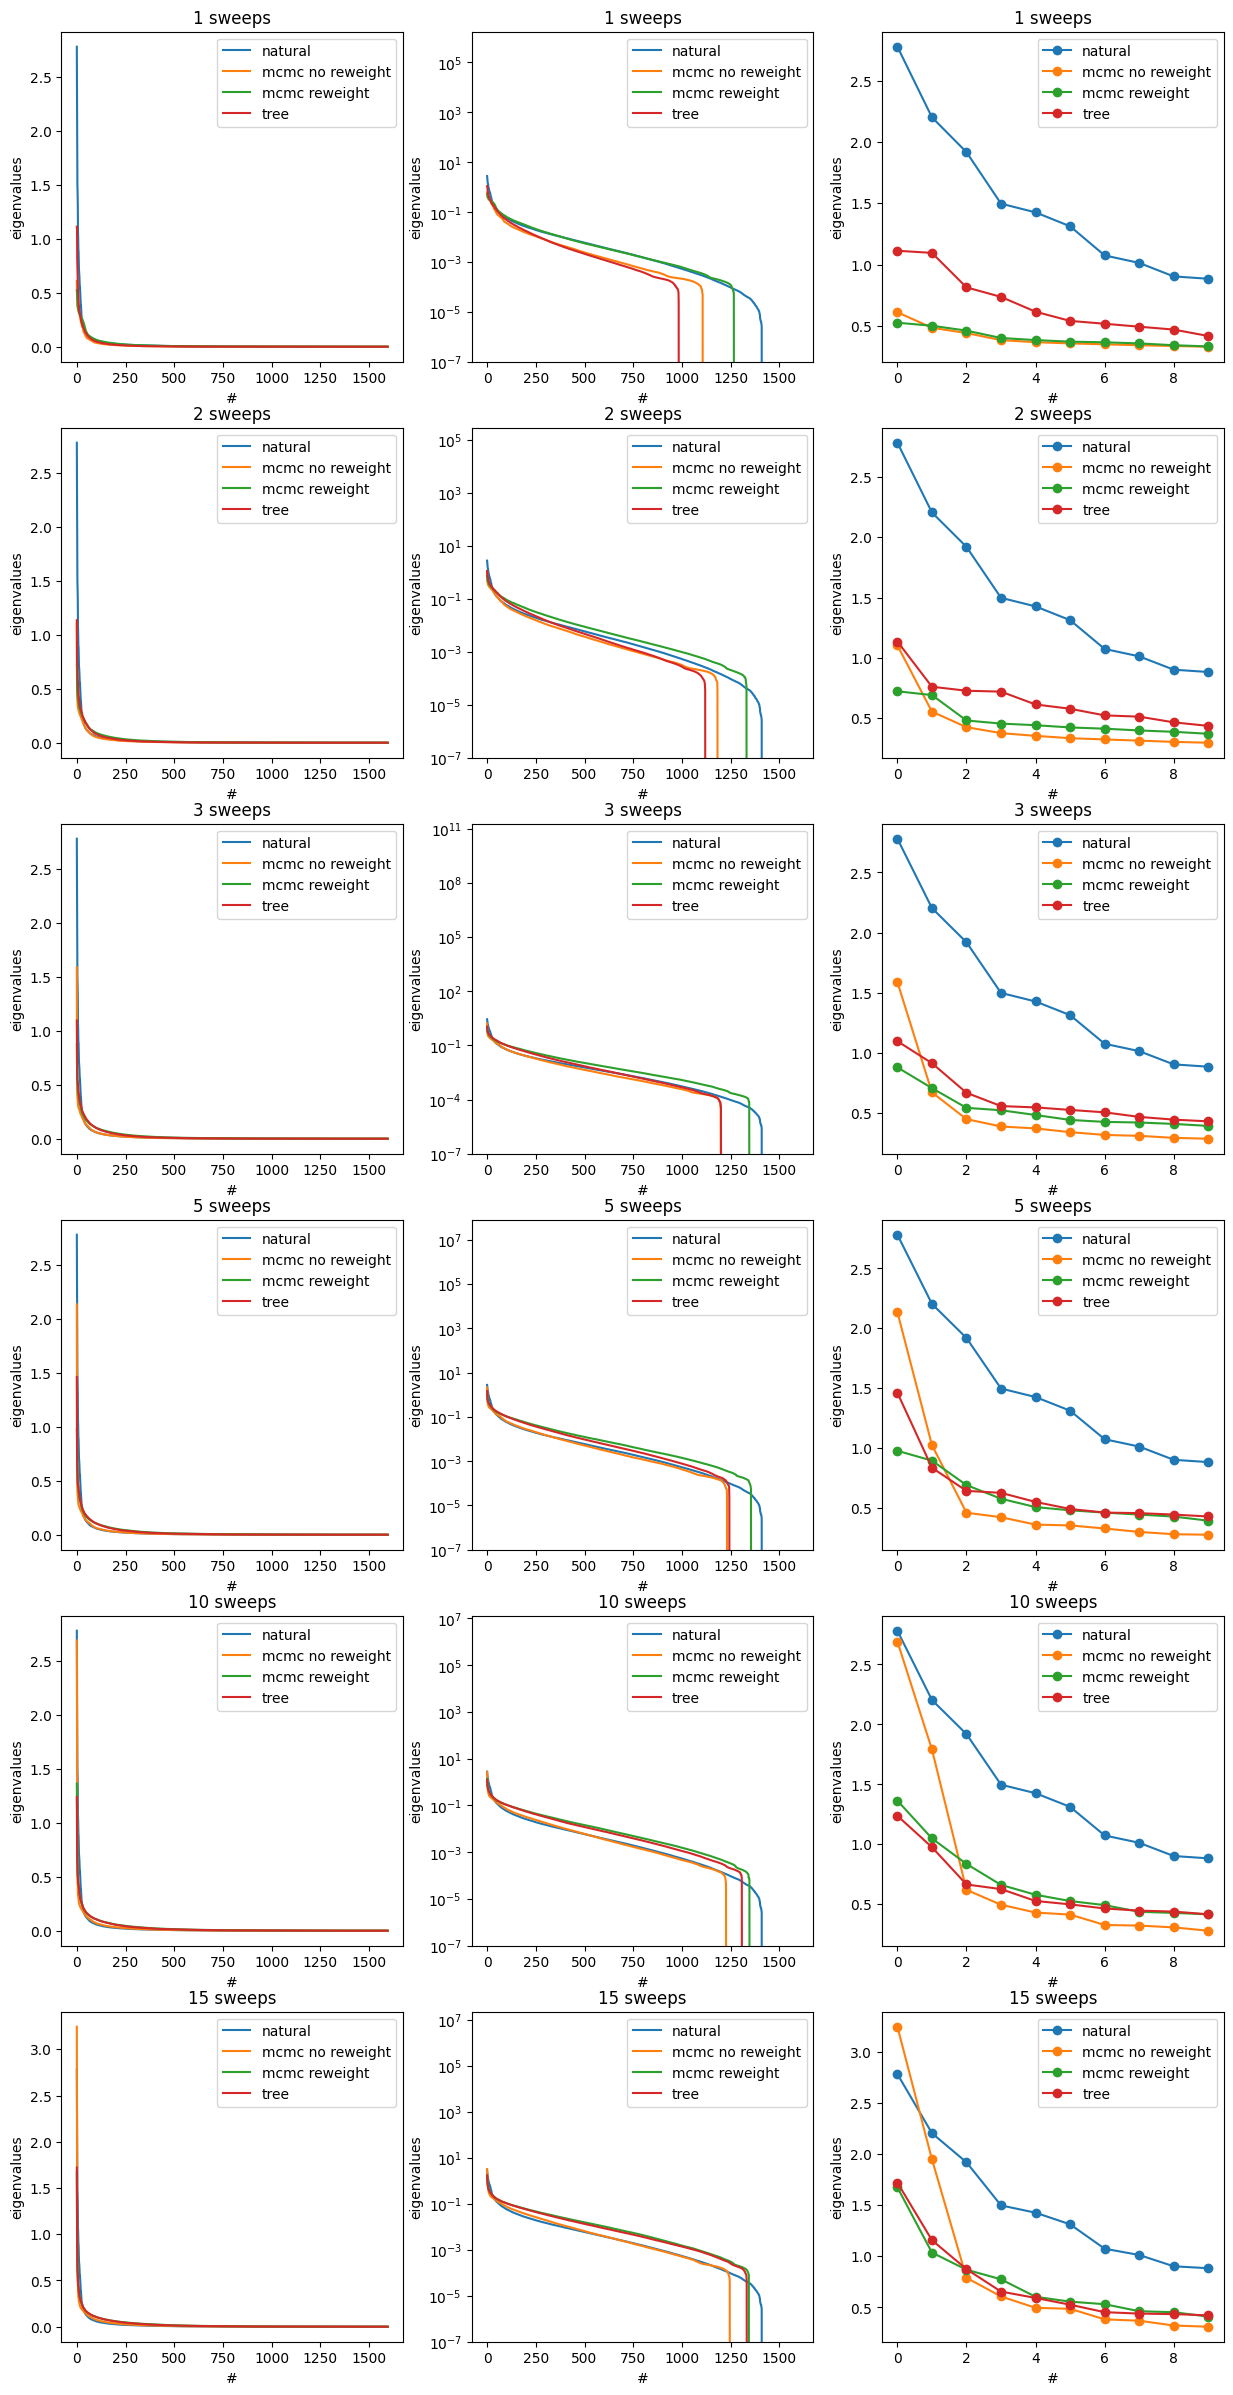

In [80]:
fig, ax = subplots(length(n_sweep_mcmc),3,5)

for (i, n_sweep) in pairs(n_sweep_mcmc)
    ax[i,1].plot(sort(spectrum_natural, rev=true), label="natural")
    ax[i,1].plot(sort(spectrum_mcmc_no_reweight[n_sweep], rev=true), label="mcmc no reweight") 
    ax[i,1].plot(sort(spectrum_mcmc_reweight[n_sweep], rev=true), label="mcmc reweight")
    ax[i,1].plot(sort(spectrum_tree[n_sweep], rev=true), label="tree")
    ax[i,1].legend()    
    ax[i,1].set_ylabel("eigenvalues")
    ax[i,1].set_xlabel("#")  
    ax[i,1].set_title("$n_sweep sweeps")

    ax[i,2].plot(sort(spectrum_natural, rev=true), label="natural")
    ax[i,2].plot(sort(spectrum_mcmc_no_reweight[n_sweep], rev=true), label="mcmc no reweight") 
    ax[i,2].plot(sort(spectrum_mcmc_reweight[n_sweep], rev=true), label="mcmc reweight")
    ax[i,2].plot(sort(spectrum_tree[n_sweep], rev=true), label="tree")
    ax[i,2].legend()    
    ax[i,2].set_ylabel("eigenvalues")
    ax[i,2].set_xlabel("#")  
    ax[i,2].set_yscale(:log)
    ax[i,2].set_ylim(bottom=1e-7)
    ax[i,2].set_title("$n_sweep sweeps")

    k_largest_eigenvalues = 10
    ax[i,3].plot(sort(spectrum_natural, rev=true)[1:k_largest_eigenvalues], label="natural", marker="o")
    ax[i,3].plot(sort(spectrum_mcmc_no_reweight[n_sweep], rev=true)[1:k_largest_eigenvalues], label="mcmc no reweight", marker="o") 
    ax[i,3].plot(sort(spectrum_mcmc_reweight[n_sweep], rev=true)[1:k_largest_eigenvalues], label="mcmc reweight", marker="o")
    ax[i,3].plot(sort(spectrum_tree[n_sweep], rev=true)[1:k_largest_eigenvalues], label="tree", marker="o")
    ax[i,3].legend()    
    ax[i,3].set_ylabel("eigenvalues")
    ax[i,3].set_xlabel("#")
    ax[i,3].set_title("$n_sweep sweeps")
end

gcf()

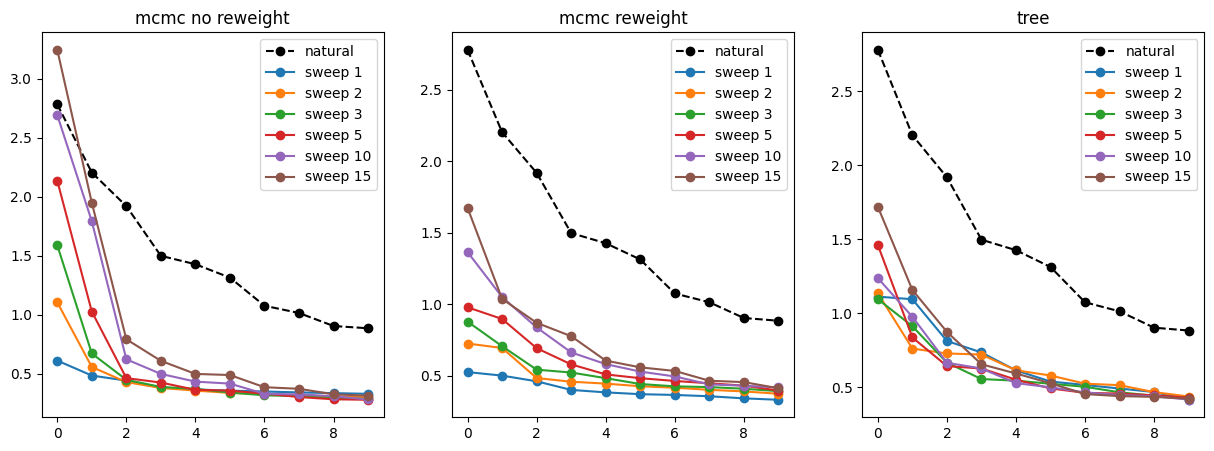

In [87]:
fig, ax = subplots(1,3,5)

map(x->x.plot(sort(spectrum_natural, rev=true)[1:k_largest_eigenvalues], label="natural", marker="o", color="black", linestyle="--"), ax)

for n_sweep in n_sweep_mcmc
    k_largest_eigenvalues = 10
    
    ax[1].plot(sort(spectrum_mcmc_no_reweight[n_sweep], rev=true)[1:k_largest_eigenvalues], label="sweep $n_sweep", marker="o")
    ax[1].set_title("mcmc no reweight")
    ax[1].legend()

    ax[2].plot(sort(spectrum_mcmc_reweight[n_sweep], rev=true)[1:k_largest_eigenvalues], label="sweep $n_sweep", marker="o")
    ax[2].set_title("mcmc reweight")
    ax[2].legend()

    ax[3].plot(sort(spectrum_tree[n_sweep], rev=true)[1:k_largest_eigenvalues], label="sweep $n_sweep", marker="o") 
    ax[3].set_title("tree")
    ax[3].legend()
end
gcf()

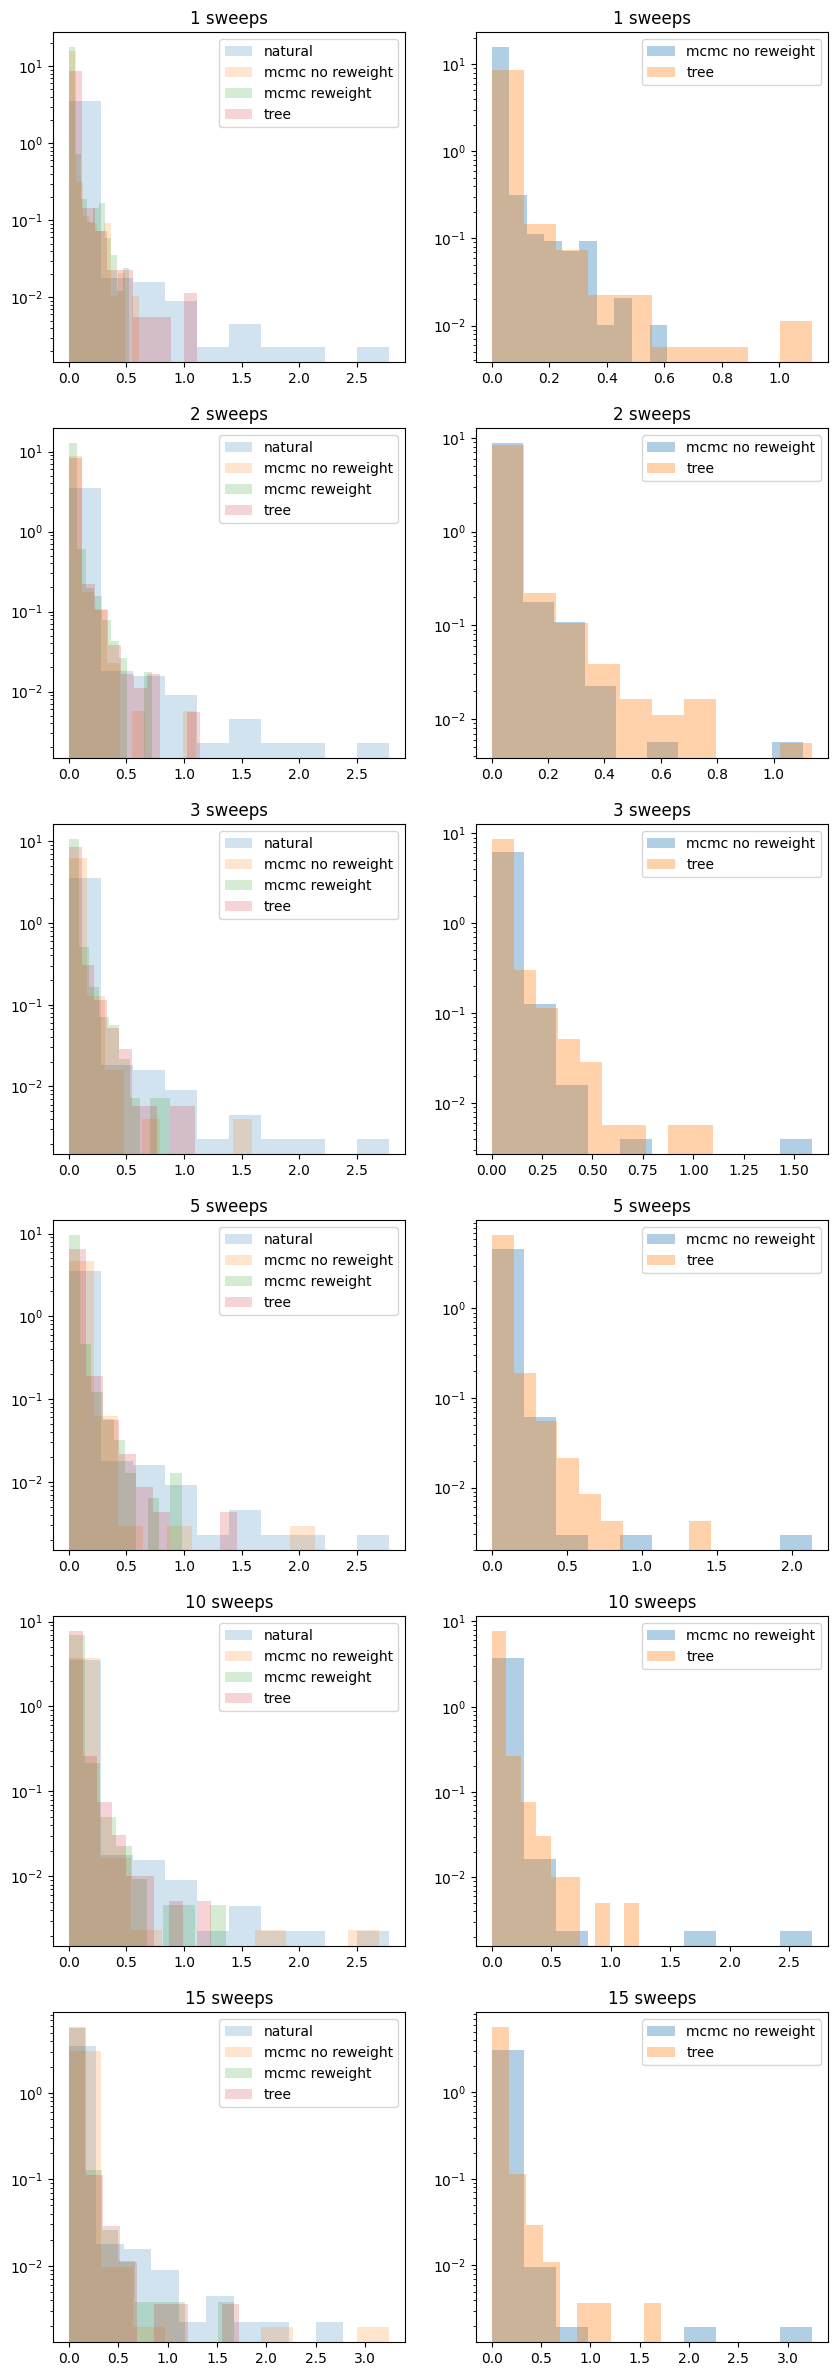

In [81]:
fig, ax = subplots(length(n_sweep_mcmc),2,5)

for (i, n_sweep) in pairs(n_sweep_mcmc)
    ax[i,1].hist(spectrum_natural, label="natural", alpha=0.2, density=true)
    ax[i,1].hist(spectrum_mcmc_no_reweight[n_sweep], label="mcmc no reweight", alpha=0.2, density=true)  
    ax[i,1].hist(spectrum_mcmc_reweight[n_sweep], label="mcmc reweight", alpha=0.2, density=true)    
    ax[i,1].hist(spectrum_tree[n_sweep], label="tree", alpha=0.2, density=true)
    ax[i,1].legend()
    ax[i,1].set_yscale(:log)
    ax[i,1].set_title("$n_sweep sweeps")

    ax[i,2].hist(spectrum_mcmc_no_reweight[n_sweep], label="mcmc no reweight", alpha=0.35, density=true)     
    ax[i,2].hist(spectrum_tree[n_sweep], label="tree", alpha=0.35, density=true)
    ax[i,2].legend()
    ax[i,2].set_yscale(:log)
    ax[i,2].set_title("$n_sweep sweeps")
end


gcf()

# PCA analysis simulated

In [ ]:
x_mcmc_reweight = reshape(Flux.onehotbatch(msa_mcmc_reweight, collect(1:q)), L*q, :)
x_mcmc_no_reweight =reshape(Flux.onehotbatch(msa_mcmc_no_reweight, collect(1:q)), L*q, :)
x_tree =reshape(Flux.onehotbatch(msa_tree, collect(1:q)), L*q, :);

In [ ]:
pca_tree = fit(PCA, x_tree)
pca_no_reweight = fit(PCA, x_mcmc_no_reweight)
pca_reweight = fit(PCA, x_mcmc_reweight);

In [ ]:
fig, ax = subplots(1,2,5)
ax[1].plot(pca_tree.prinvars, marker="o", label="tree")
ax[1].plot(pca_no_reweight.prinvars, marker="o", label="mcmc no reweight")
ax[1].plot(pca_reweight.prinvars, marker="o", label="mcmc reweight")
ax[1].legend()

ax[2].plot([sum(pca_tree.prinvars[1:i])/pca_tree.tprinvar for i in eachindex(pca_tree.prinvars)], marker="o", label="tree")
ax[2].plot([sum(pca_no_reweight.prinvars[1:i])/pca_no_reweight.tprinvar for i in eachindex(pca_no_reweight.prinvars)], marker="o", label="mcmc no reweight")
ax[2].plot([sum(pca_reweight.prinvars[1:i])/pca_reweight.tprinvar for i in eachindex(pca_reweight.prinvars)], marker="o", label="mcmc reweight")
ax[2].legend()
gcf()

In [ ]:
x_pca_mcmc_reweight = transform(pca_reweight, x_mcmc_reweight)
x_pca_mcmc_no_reweight = transform(pca_no_reweight, x_mcmc_no_reweight)
x_pca_tree = transform(pca_tree, x_tree);

In [ ]:
fig, ax = subplots(1, 3, 4)

ax[1].scatter(x_pca_tree[1,:], x_pca_tree[2,:], edgecolors="black")
ax[1].set_xlabel("PC1")
ax[1].set_ylabel("PC2")
ax[1].set_title("tree")

ax[2].scatter(x_pca_mcmc_no_reweight[1,:], x_pca_mcmc_no_reweight[2,:], edgecolors="black") 
ax[2].set_xlabel("PC1")
ax[2].set_ylabel("PC2")
ax[2].set_title("mcmc no reweight")

ax[3].scatter(x_pca_mcmc_reweight[1,:], x_pca_mcmc_reweight[2,:], edgecolors="black")
ax[3].set_xlabel("PC1")
ax[3].set_ylabel("PC2")
ax[3].set_title("mcmc reweight")

gcf()

# PCA analysis natural

In [ ]:
x_msa_natural = reshape(Flux.onehotbatch(msa_z, collect(1:q)), L*q, :)
pca_natural = fit(PCA, x_msa_natural)
x_pca_natural = transform(pca_natural, x_msa_natural);

In [ ]:
x_pca_tree_natural = transform(pca_tree, x_msa_natural);

In [ ]:
fig, ax = subplots(1,2,5)
ax[1].plot(pca_natural.prinvars, marker="o")
ax[2].plot([sum(pca_natural.prinvars[1:i])/pca_natural.tprinvar for i in eachindex(pca_natural.prinvars)], marker="o")
gcf()

In [ ]:
fig, ax = subplots(1,2,5)
ax[1].hist2d(x_pca_natural[1,:], x_pca_natural[2,:], bins=50) 
ax[1].set_title("PCA natural sequences")
ax[1].set_xlabel("PC1")
ax[1].set_ylabel("PC2")

ax[2].hist2d(x_pca_tree_natural[1,:], x_pca_tree_natural[2,:], bins=50)
ax[2].set_title("natural sequences projected on PCs of tree sample")
ax[2].set_xlabel("PC1")
ax[2].set_ylabel("PC2")
gcf()

In [ ]:
mean_pca = vec(Statistics.mean(x_pca_tree_natural, dims=2))
cov_pca = Statistics.cov(x_pca_tree_natural, dims=2);

In [ ]:
samples = rand(MvNormal(mean_pca, cov_pca), 1000)
figure()
title("samples from estimated distribution")
hist2D(samples[1,:], samples[2,:], bins=50)
xlabel("PC1")
ylabel("PC2")
gcf()

In [ ]:
J_pca = - pca_tree.proj * cov_pca * pca_tree.proj'
h_pca = vec(2*( pca_tree.mean' * pca_tree.proj * inv(cov_pca) * pca_tree.proj' + mean_pca' * inv(cov_pca) * pca_tree.proj' ))

In [ ]:
J_pca = permutedims(reshape(J_pca, q, L, q, L), (1,3,2,4))
h_pca = reshape(h_pca, q, L)

In [ ]:
potts_pca = PottsGraph(J_pca, h_pca, 1.0, aa_alphabet)

In [ ]:
msa_energies_pca = map(x->energy(x, potts_pca), eachcol(msa_z))
msa_tree_energies_reweight = map(x->energy(x, potts_reweight), eachcol(msa_tree))
msa_tree_energies_pca = map(x->energy(x, potts_pca), eachcol(msa_tree));

In [ ]:
fig, ax = subplots(1,2,6)
ax[1].scatter(msa_energies_reweight, msa_energies_pca)
ax[1].set_title("energies natural sequences")
ax[1].set_xlabel("energies adabmDCA (reweighted)")
ax[1].set_ylabel("energies Gaussian DCA on PCs")
pearson_natural = cor(msa_energies_reweight, msa_energies_pca)
ax[1].text(0.1, 0.8, transform=ax[1].transAxes, "Pearson=" * string(round(pearson_natural, digits=2)), color="red", fontsize=10)

ax[2].scatter(msa_tree_energies_reweight, msa_tree_energies_pca)
ax[2].set_title("energies tree sequences (adabmDCA parameters)")
ax[2].set_xlabel("energies adabmDCA (reweighted)")
ax[2].set_ylabel("energies Gaussian DCA on PCs")
pearson_tree = cor(msa_tree_energies_reweight, msa_tree_energies_pca)
ax[2].text(0.1, 0.8, transform=ax[2].transAxes, "Pearson=" * string(round(pearson_tree, digits=2)), color="red", fontsize=10)
gcf()

In [ ]:
results_tree_pca = [mcmc_sample(potts_pca, 1, parameters_mcmc, init=wt_int) for _ in 1:n_samples_mcmc]
msa_tree_pca = hcat(map(x->x.sequences.data , results_mcmc_reweight)...);

In [ ]:
n_samples = 2000
sample_idx = randperm(n_samples_tree)[1:n_samples]
dist_pairwise_tree_pca = zeros(Int, n_samples*(n_samples-1)÷2)
cnt =1
for i in 1:n_samples
    for j in 1:i-1
        dist_pairwise_tree_pca[cnt] = sum(msa_tree_pca[:,sample_idx[i]] .!= msa_tree_pca[:,sample_idx[j]])
        cnt += 1
    end
end

In [ ]:
fig, ax = subplots(2,2,5)
fig.suptitle("Pairwise Hamming distances")

ax[1,1].hist(dist_pairwise_mcmc_no_reweight, bins=30, label="no reweight", alpha=0.3, density=true)
ax[1,1].hist(dist_pairwise_mcmc_reweight, bins=30, label="reweight", alpha=0.3, density=true)
ax[1,1].set_title("mcmc sampling")
ax[1,1].set_xlabel("Hamming distance")
ax[1,1].legend()

ax[1,2].hist(dist_pairwise_tree, bins=30, density=true, alpha=0.3, label="adabmDCA")
ax[1,2].hist(dist_pairwise_tree_pca, bins=30, density=true, alpha=0.3, label="Gaussian DCA on PCs")
ax[1,2].set_xlabel("Hamming distance")
ax[1,2].set_title("tree sampling")
ax[1,2].legend()

ax[2,1].hist(dist_pairwise_mcmc_no_reweight, bins=30, label="no reweight", alpha=0.3, density=true)
ax[2,1].hist(dist_pairwise_mcmc_reweight, bins=30, label="reweight", alpha=0.3, density=true)
ax[2,1].set_title("mcmc sampling")
ax[2,1].set_xlabel("Hamming distance")
ax[2,1].set_yscale(:log)
ax[2,1].legend()

ax[2,2].hist(dist_pairwise_tree, bins=30, density=true, alpha=0.3, label="adabmDCA")
ax[2,2].hist(dist_pairwise_tree_pca, bins=30, density=true, alpha=0.3, label="Gaussian DCA on PCs")
ax[2,2].set_xlabel("Hamming distance")
ax[2,2].set_title("tree sampling")
ax[2,2].legend()
ax[2,2].set_yscale(:log)

gcf()

In [ ]:
cor_tree_pca = compute_corr_matrix(msa_tree_pca)
spectrum_tree_pca = eigen(cor_tree_pca).values;

In [ ]:
figure()
hist(spectrum_tree, label="tree adabmDCA", alpha=0.3, density=true)
hist(spectrum_tree_pca, label="tree Gaussian DCA on PCs", alpha=0.3, density=true)
legend()
yscale(:log)
ylabel("density")
xlabel("eigenvalue")
title("spectrum correlation matrix")
gcf()

Logo sample tree

In [ ]:
figure(figsize=(50,2))
logo_from_matrix(TreeCorr.compute_frequencies_from(msa_tree, q=q),
    String(map(x->aa_alphabet.index_to_char[x], collect(1:q)))) |> plot_sequence_logo_aa
gcf()

Logo sample MCMC (Gaussian DCA on PC space)

In [ ]:
figure(figsize=(50,2))
logo_from_matrix(TreeCorr.compute_frequencies_from(msa_tree_pca, q=q),
    String(map(x->aa_alphabet.index_to_char[x], collect(1:q)))) |> plot_sequence_logo_aa
gcf()